In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda

if device.type == 'cuda':
    print(torch.cuda
          .get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 960
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
torch.cuda.empty_cache()

In [3]:
%load_ext autoreload
%autoreload 2


In [20]:
import os, sys
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
import scipy
from skimage.io import imread, imsave
from skimage.transform import estimate_transform, warp, resize, rescale
from glob import glob
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image 
import time
import matplotlib.pyplot as plt
import face_alignment
import torch.nn as nn
import torch.nn.functional as F
import imageio

from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import rasterize_meshes


In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [18]:
import argparse
from tqdm import tqdm
from lib.baldnet import BaldNet
from lib.datasets import test_dataset 
from lib.utils import util
from lib.utils.config import cfg
from lib.utils.segment import returnfacebbox, return_skin_mask
from lib.utils.renderer import SRenderY, Pytorch3dRasterizer



In [7]:
class TestDataset(Dataset):
    def __init__(self, crop_size=224,):
        self.imagefolder = 'G:/FaceReconstruction/Flame/DECA_master/InputOg'
        self.imagelist = os.listdir(self.imagefolder)
        
        self.crop_size = crop_size
            
    def __len__(self):
        return len(self.imagelist)

    def __getitem__(self, index):
        imagepath = os.path.join(self.imagefolder, self.imagelist[index] ) #+ '.jpg'
       
        imagename = os.path.basename(imagepath).split('.')[0]
        image = Image.open(imagepath).convert("RGB")
        
        face, bbox_coordinates = returnfacebbox(np.array(image), margin = 0.05, msk_type='full', getbbox=True)
        cropped_image = cv2.resize(np.array(face), (self.crop_size, self.crop_size),interpolation=cv2.INTER_CUBIC)
        
         
        cropped_image = np.array(cropped_image)/255
       

        cropped_image = cropped_image.transpose(2,0,1)
        return {'image': torch.tensor(cropped_image).float(),
                'imagename':imagename,
               
                }

In [8]:
# cfg.model.topology_path = "./data/head_template_uv.obj"
# cfg.pretrained_modelpath = "./data/model_lfpw_dice.tar"
# cfg.model.flame_model_path = "./data/generic_model_avg5.pkl"
# cfg.model.flame_lmk_embedding_path = os.path.join(deca_cfg.deca_dir, 'data', 'landmark_embedding_71_upper.npy') 


In [9]:
baldnet = BaldNet(config = cfg,)

fc.weight  not available in reconstructed resnet
fc.bias  not available in reconstructed resnet
creating the FLAME Decoder
trained model found. load G:\FaceReconstruction\Flame\BaldNet_inference\data\model_lfpw_dice.tar


G:\FaceReconstruction\pytorchGpu\lib\site-packages\pytorch3d\io\obj_io.py:531: UserWarning: Mtl file does not exist: G:\FaceReconstruction\Flame\BaldNet_inference\data\template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [10]:
output_dir = "G:/FaceReconstruction/Flame/DECA_master"

os.makedirs(os.path.join(output_dir, 'ogcrop_test'), exist_ok=True)
savefolder = os.path.join(output_dir, 'ogcrop_test') 
os.makedirs(savefolder, exist_ok=True)

# run now validation images
dataset = TestDataset()
dataloader = DataLoader(dataset, batch_size=1, shuffle=False,
                    num_workers=0,
                    pin_memory=False,
                    drop_last=False)


faces = baldnet.flame.faces_tensor.cpu().numpy()

for i, batch in enumerate(tqdm(dataloader)):
    images = batch['image'].to(device)
    imagename = batch['imagename']
    print(imagename)
    
    with torch.no_grad():
        codedict = baldnet.encode(images)
        opdict, visdict = baldnet.decode(codedict)
        
        
    print("vis" , visdict.keys())
    print("opt" , opdict.keys())

    break

  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

['000004']


  0%|                                                                                           | 0/44 [00:12<?, ?it/s]

vis dict_keys(['inputs', 'landmarks2d', 'landmarks3d', 'shape_images', 'albedo', 'rendered_images'])
opt dict_keys(['vertices', 'normals', 'transformed_vertices', 'landmarks2d', 'landmarks3d', 'landmarks3d_world', 'uv_normals', 'uv_texture_gt', 'displacement_map', 'albedo', 'uv_texture'])


In [51]:
visdict['rendered_images'].shape

torch.Size([1, 3, 224, 224])

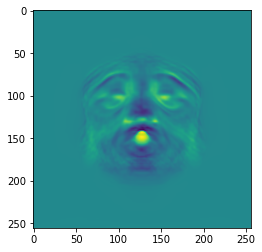

In [12]:
plt.imshow(opdict['uv_z'][0][0].cpu().numpy())

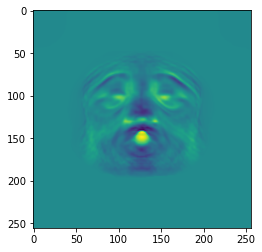

In [54]:
plt.imshow((opdict['uv_z']*baldnet.uv_face_eye_mask)[0].permute(1,2,0).cpu().numpy())


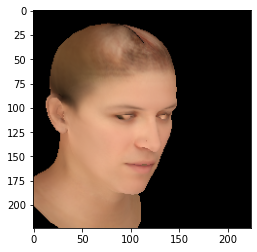

In [52]:
plt.imshow(visdict['rendered_images'][0].permute(1,2,0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


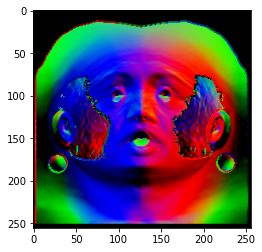

In [28]:
plt.imshow(opdict['uv_detail_normals'][0].permute(1,2,0).cpu().numpy())

In [38]:
opdict['normals'][0].shape

torch.Size([1, 5023, 3])

In [9]:
#head 
#vert: 3931
#uv : 3962

#eye
#vert: 3931 - 5023
#uv: 3962-5118

In [12]:
# uv_z = opdict['uv_z'] 
coarse_verts =  opdict['vertices'] 
coarse_normals = opdict['normals']
eyeFaces = baldnet.render.eyeFaces
headFaces = baldnet.render.headFaces

In [21]:

class SRenderY(nn.Module):
    def __init__(self, image_size, obj_filename, uv_size=256, rasterizer_type='pytorch3d'):
        super(SRenderY, self).__init__()
        self.image_size = image_size
        self.uv_size = uv_size

        verts, faces, aux = load_obj(obj_filename)
        uvcoords = aux.verts_uvs[None, ...]      # (N, V, 2)
        uvfaces = faces.textures_idx[None, ...] # (N, F, 3)
        faces = faces.verts_idx[None,...]

        eye_face_indices = np.load(os.path.join(os.path.dirname(obj_filename),'seperated_obj', 'eye_face_indices.npy')).tolist()
        eye_left_indices = np.load(os.path.join(os.path.dirname(obj_filename),'seperated_obj', 'eye_left.npy')).tolist()
        eye_right_indices = np.load(os.path.join(os.path.dirname(obj_filename),'seperated_obj', 'eye_right.npy')).tolist()

        self.eyeFaces = np.array(eye_face_indices)
        self.headFaces = [ele for ele in np.arange(faces.shape[1]) if ele not in self.eyeFaces]
        self.eyeLeftIndices = np.array(eye_left_indices)
        self.eyeRightIndices = np.array(eye_right_indices)


        if rasterizer_type == 'pytorch3d':
            self.rasterizer = Pytorch3dRasterizer(image_size)
            self.uv_rasterizer = Pytorch3dRasterizer(uv_size)

        # faces
        dense_triangles = util.generate_triangles(uv_size, uv_size)
        self.register_buffer('dense_faces', torch.from_numpy(dense_triangles).long()[None,:,:])
        self.register_buffer('faces', faces)
        self.register_buffer('raw_uvcoords', uvcoords)
        uvcoords_head = uvcoords[:,:3962,:]
        uvfaces_head = uvfaces[:,headFaces,:]

        # uv coords
        uvcoords = torch.cat([uvcoords_head, uvcoords_head[:,:,0:1]*0.+1.], -1) #[bz, ntv, 3]
        uvcoords = uvcoords*2 - 1; uvcoords[...,1] = -uvcoords[...,1]
        face_uvcoords = util.face_vertices(uvcoords, uvfaces_head)
        self.register_buffer('uvcoords', uvcoords)
        self.register_buffer('uvfaces', uvfaces)
        self.register_buffer('face_uvcoords', face_uvcoords)

        # shape colors, for rendering shape overlay
        colors = torch.tensor([180, 180, 180])[None, None, :].repeat(1, faces.max()+1, 1).float()/255.
        face_colors = util.face_vertices(colors, faces)
        self.register_buffer('face_colors', face_colors)

        ## SH factors for lighting
        pi = np.pi
        constant_factor = torch.tensor([1/np.sqrt(4*pi), ((2*pi)/3)*(np.sqrt(3/(4*pi))), ((2*pi)/3)*(np.sqrt(3/(4*pi))),\
                           ((2*pi)/3)*(np.sqrt(3/(4*pi))), (pi/4)*(3)*(np.sqrt(5/(12*pi))), (pi/4)*(3)*(np.sqrt(5/(12*pi))),\
                           (pi/4)*(3)*(np.sqrt(5/(12*pi))), (pi/4)*(3/2)*(np.sqrt(5/(12*pi))), (pi/4)*(1/2)*(np.sqrt(5/(4*pi)))]).float()
        self.register_buffer('constant_factor', constant_factor)
    
    def forward(self, vertices, transformed_vertices, albedos, lights=None, light_type='point'):
        '''
        -- Texture Rendering
        vertices: [batch_size, V, 3], vertices in world space, for calculating normals, then shading
        transformed_vertices: [batch_size, V, 3], range:normalized to [-1,1], projected vertices in image space (that is aligned to the iamge pixel), for rasterization
        albedos: [batch_size, 3, h, w], uv map
        lights: 
            spherical homarnic: [N, 9(shcoeff), 3(rgb)]
            points/directional lighting: [N, n_lights, 6(xyzrgb)]
        light_type:
            point or directional
        '''
        batch_size = vertices.shape[0]
        ## rasterizer near 0 far 100. move mesh so minz larger than 0
        transformed_vertices[:,:,2] = transformed_vertices[:,:,2] + 10
        # attributes
        face_vertices = util.face_vertices(vertices, self.faces.expand(batch_size, -1, -1))
        normals = util.vertex_normals(vertices, self.faces.expand(batch_size, -1, -1)); face_normals = util.face_vertices(normals, self.faces.expand(batch_size, -1, -1))
        transformed_normals = util.vertex_normals(transformed_vertices, self.faces.expand(batch_size, -1, -1)); transformed_face_normals = util.face_vertices(transformed_normals, self.faces.expand(batch_size, -1, -1))
        
        attributes = torch.cat([self.face_uvcoords.expand(batch_size, -1, -1, -1), 
                                transformed_face_normals.detach(), 
                                face_vertices.detach(), 
                                face_normals], 
                                -1)
        # rasterize
        rendering = self.rasterizer(transformed_vertices, self.faces.expand(batch_size, -1, -1), attributes)
        
        ####
        # vis mask
        alpha_images = rendering[:, -1, :, :][:, None, :, :].detach()

        # albedo
        uvcoords_images = rendering[:, :3, :, :]; grid = (uvcoords_images).permute(0, 2, 3, 1)[:, :, :, :2]
        albedo_images = F.grid_sample(albedos, grid, align_corners=False)

        # visible mask for pixels with positive normal direction
        transformed_normal_map = rendering[:, 3:6, :, :].detach()
        pos_mask = (transformed_normal_map[:, 2:, :, :] < -0.05).float()

        # shading
        normal_images = rendering[:, 9:12, :, :]
        if lights is not None:
            if lights.shape[1] == 9:
                shading_images = self.add_SHlight(normal_images, lights)
            else:
                if light_type=='point':
                    vertice_images = rendering[:, 6:9, :, :].detach()
                    shading = self.add_pointlight(vertice_images.permute(0,2,3,1).reshape([batch_size, -1, 3]), normal_images.permute(0,2,3,1).reshape([batch_size, -1, 3]), lights)
                    shading_images = shading.reshape([batch_size, albedo_images.shape[2], albedo_images.shape[3], 3]).permute(0,3,1,2)
                else:
                    shading = self.add_directionlight(normal_images.permute(0,2,3,1).reshape([batch_size, -1, 3]), lights)
                    shading_images = shading.reshape([batch_size, albedo_images.shape[2], albedo_images.shape[3], 3]).permute(0,3,1,2)
            images = albedo_images*shading_images
        else:
            images = albedo_images
            shading_images = images.detach()*0.

        outputs = {
            'images': images*alpha_images,
            'albedo_images': albedo_images*alpha_images,
            'alpha_images': alpha_images,
            'pos_mask': pos_mask,
            'shading_images': shading_images,
            'grid': grid,
            'normals': normals,
            'normal_images': normal_images*alpha_images,
            'transformed_normals': transformed_normals,
        }
        
        return outputs

    def add_SHlight(self, normal_images, sh_coeff):
        '''
            sh_coeff: [bz, 9, 3]
        '''
        N = normal_images
        sh = torch.stack([
                N[:,0]*0.+1., N[:,0], N[:,1], \
                N[:,2], N[:,0]*N[:,1], N[:,0]*N[:,2], 
                N[:,1]*N[:,2], N[:,0]**2 - N[:,1]**2, 3*(N[:,2]**2) - 1
                ], 
                1) # [bz, 9, h, w]
        sh = sh*self.constant_factor[None,:,None,None]
        shading = torch.sum(sh_coeff[:,:,:,None,None]*sh[:,:,None,:,:], 1) # [bz, 9, 3, h, w]  
        return shading

    def add_pointlight(self, vertices, normals, lights):
        '''
            vertices: [bz, nv, 3]
            lights: [bz, nlight, 6]
        returns:
            shading: [bz, nv, 3]
        '''
        light_positions = lights[:,:,:3]; light_intensities = lights[:,:,3:]
        directions_to_lights = F.normalize(light_positions[:,:,None,:] - vertices[:,None,:,:], dim=3)
        # normals_dot_lights = torch.clamp((normals[:,None,:,:]*directions_to_lights).sum(dim=3), 0., 1.)
        normals_dot_lights = (normals[:,None,:,:]*directions_to_lights).sum(dim=3)
        shading = normals_dot_lights[:,:,:,None]*light_intensities[:,:,None,:]
        return shading.mean(1)

    def add_directionlight(self, normals, lights):
        '''
            normals: [bz, nv, 3]
            lights: [bz, nlight, 6]
        returns:
            shading: [bz, nv, 3]
        '''
        light_direction = lights[:,:,:3]; light_intensities = lights[:,:,3:]
        directions_to_lights = F.normalize(light_direction[:,:,None,:].expand(-1,-1,normals.shape[1],-1), dim=3)
        # normals_dot_lights = torch.clamp((normals[:,None,:,:]*directions_to_lights).sum(dim=3), 0., 1.)
        # normals_dot_lights = (normals[:,None,:,:]*directions_to_lights).sum(dim=3)
        normals_dot_lights = torch.clamp((normals[:,None,:,:]*directions_to_lights).sum(dim=3), 0., 1.)
        shading = normals_dot_lights[:,:,:,None]*light_intensities[:,:,None,:]
        return shading.mean(1)

    def render_shape(self, vertices, transformed_vertices, images=None,detail_normal_images=None, lights=None):
        '''
        -- rendering shape with detail normal map
        '''
        batch_size = vertices.shape[0]
        # set lighting
        if lights is None:
            light_positions = torch.tensor(
                [
                [-1,1,1],
                [1,1,1],
                [-1,-1,1],
                [1,-1,1],
                [0,0,1]
                ]
            )[None,:,:].expand(batch_size, -1, -1).float()
            light_intensities = torch.ones_like(light_positions).float()*1.7
            lights = torch.cat((light_positions, light_intensities), 2).to(vertices.device)
        transformed_vertices[:,:,2] = transformed_vertices[:,:,2] + 10

        # Attributes
        face_vertices = util.face_vertices(vertices, self.faces.expand(batch_size, -1, -1))
        normals = util.vertex_normals(vertices, self.faces.expand(batch_size, -1, -1)); face_normals = util.face_vertices(normals, self.faces.expand(batch_size, -1, -1))
        transformed_normals = util.vertex_normals(transformed_vertices, self.faces.expand(batch_size, -1, -1)); transformed_face_normals = util.face_vertices(transformed_normals, self.faces.expand(batch_size, -1, -1))
        attributes = torch.cat([self.face_colors.expand(batch_size, -1, -1, -1), 
                        transformed_face_normals.detach(), 
                        face_vertices.detach(), 
                        face_normals], 
                        -1)
        # rasterize
        rendering = self.rasterizer(transformed_vertices, self.faces.expand(batch_size, -1, -1), attributes)

        ####
        alpha_images = rendering[:, -1, :, :][:, None, :, :].detach()

        # albedo
        albedo_images = rendering[:, :3, :, :]
        # mask
        transformed_normal_map = rendering[:, 3:6, :, :].detach()
        pos_mask = (transformed_normal_map[:, 2:, :, :] < 0.15).float()

        # shading
        normal_images = rendering[:, 9:12, :, :].detach()
        vertice_images = rendering[:, 6:9, :, :].detach()
        if detail_normal_images is not None:
            normal_images = detail_normal_images

        shading = self.add_directionlight(normal_images.permute(0,2,3,1).reshape([batch_size, -1, 3]), lights)
        shading_images = shading.reshape([batch_size, albedo_images.shape[2], albedo_images.shape[3], 3]).permute(0,3,1,2).contiguous()        
        shaded_images = albedo_images*shading_images
        shaded_images.mean(1)

        alpha_images = alpha_images*pos_mask
        if images is None:
            shape_images = shaded_images*alpha_images + torch.zeros_like(shaded_images).to(vertices.device)*(1-alpha_images)
        else:
            shape_images = shaded_images*alpha_images + images*(1-alpha_images)
        return shape_images
    
    def render_depth(self, transformed_vertices):
        '''
        -- rendering depth
        '''
        batch_size = transformed_vertices.shape[0]

        transformed_vertices[:,:,2] = transformed_vertices[:,:,2] - transformed_vertices[:,:,2].min()
        z = -transformed_vertices[:,:,2:].repeat(1,1,3).clone()
        z = z-z.min()
        z = z/z.max()
        # Attributes
        attributes = util.face_vertices(z, self.faces.expand(batch_size, -1, -1))
        # rasterize
        transformed_vertices[:,:,2] = transformed_vertices[:,:,2] + 10
        rendering = self.rasterizer(transformed_vertices, self.faces.expand(batch_size, -1, -1), attributes)

        ####
        alpha_images = rendering[:, -1, :, :][:, None, :, :].detach()
        depth_images = rendering[:, :1, :, :]
        return depth_images
    
    def render_normal(self, transformed_vertices, normals):
        '''
        -- rendering normal
        '''
        batch_size = normals.shape[0]

        # Attributes
        attributes = util.face_vertices(normals, self.faces.expand(batch_size, -1, -1))
        # rasterize
        rendering = self.rasterizer(transformed_vertices, self.faces.expand(batch_size, -1, -1), attributes)
        ####
        alpha_images = rendering[:, -1, :, :][:, None, :, :].detach()
        normal_images = rendering[:, :3, :, :]
        return normal_images

    def world2uv(self, vertices):
        '''
        warp vertices from world space to uv space
        vertices: [bz, V, 3]
        uv_vertices: [bz, 3, h, w]
        '''
        batch_size = vertices.shape[0]
        face_vertices = util.face_vertices(vertices, self.faces.expand(batch_size, -1, -1))
        uv_vertices = self.uv_rasterizer(self.uvcoords.expand(batch_size, -1, -1), self.uvfaces.expand(batch_size, -1, -1), face_vertices)[:, :3]
        return uv_vertices

In [31]:
verts, faces, aux = load_obj(cfg.model.topology_path)
uvcoords = aux.verts_uvs[None, ...]      # (N, V, 2)
uvfaces = faces.textures_idx[None, ...] # (N, F, 3)
faces = faces.verts_idx[None,...]

G:\FaceReconstruction\pytorchGpu\lib\site-packages\pytorch3d\io\obj_io.py:531: UserWarning: Mtl file does not exist: G:\FaceReconstruction\Flame\BaldNet_inference\data\template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [38]:
def face_vertices(vertices, faces):
    """ 
    :param vertices: [batch size, number of vertices, 3]
    :param faces: [batch size, number of faces, 3]
    :return: [batch size, number of faces, 3, 3]
    """
    assert (vertices.ndimension() == 3)
    assert (faces.ndimension() == 3)
    assert (vertices.shape[0] == faces.shape[0])
    assert (vertices.shape[2] == 3)
    assert (faces.shape[2] == 3)

    bs, nv = vertices.shape[:2]
    bs, nf = faces.shape[:2]
    device = vertices.device
    faces = faces + (torch.arange(bs, dtype=torch.int32).to(device) * nv)[:, None, None]
    vertices = vertices.reshape((bs * nv, 3))
    print(faces.shape)
    print(vertices.shape)
    # pytorch only supports long and byte tensors for indexing
    return vertices[faces.long()]

In [49]:
(torch.arange(1, dtype=torch.int32).to(device) * 3962)[:, None, None]

tensor([[[0]]], device='cuda:0', dtype=torch.int32)

In [45]:
uvcoords_head = uvcoords[:,:3962,:]
uvfaces_head = uvfaces[:,headFaces,:]

In [46]:
uvfaces_head.shape

torch.Size([1, 7800, 3])

In [47]:

# uv coords
uvcoords_head = torch.cat([uvcoords_head, uvcoords_head[:,:,0:1]*0.+1.], -1) #[bz, ntv, 3]
uvcoords_head = uvcoords_head*2 - 1
uvcoords_head[...,1] = -uvcoords_head[...,1]
bs, nv = uvcoords_head.shape[:2]

uvfaces_head = uvfaces_head + (torch.arange(bs, dtype=torch.int32).to(device) * nv)[:, None, None]

# face_uvcoords = face_vertices(uvcoords_head, uvfaces_head)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [35]:
uvfaces_head[0].shape

torch.Size([7800, 3])

In [17]:
render = SRenderY(224, obj_filename=cfg.model.topology_path, uv_size=cfg.model.uv_size)


G:\FaceReconstruction\pytorchGpu\lib\site-packages\pytorch3d\io\obj_io.py:531: UserWarning: Mtl file does not exist: G:\FaceReconstruction\Flame\BaldNet_inference\data\template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [14]:
verts, landmarks2d, landmarks3d = baldnet.flame(shape_params=codedict['shape'], expression_params=codedict['exp'], pose_params=codedict['pose'])
trans_verts = util.batch_orth_proj(verts, codedict['cam']); trans_verts[:,:,1:] = -trans_verts[:,:,1:]


In [ ]:
ops = self.render(verts, trans_verts, albedo, codedict['light'])


In [12]:
baldnet.render.faces.shape

torch.Size([1, 9976, 3])

In [15]:
print(len(baldnet.render.eyeFaces))
print(len(baldnet.render.headFaces))

2176
7800


In [12]:
 def world2uv( vertices , uvcoords , faces , uvfaces):
        '''
        warp vertices from world space to uv space
        vertices: [bz, V, 3]
        uv_vertices: [bz, 3, h, w]
        '''
        batch_size = vertices.shape[0]
        face_vertices = util.face_vertices(vertices, faces.expand(batch_size, -1, -1))
        uv_vertices = baldnet.render.uv_rasterizer(uvcoords.expand(batch_size, -1, -1), uvfaces.expand(batch_size, -1, -1), face_vertices)[:, :3]
        return uv_vertices

In [13]:
def displacement2normal(uv_z, coarse_verts, coarse_normals):
    ''' Convert displacement map into detail normal map
    '''
    batch_size = uv_z.shape[0]
    uv_coarse_vertices = baldnet.render.world2uv(coarse_verts).detach()
    uv_coarse_normals = baldnet.render.world2uv(coarse_normals).detach()

    uv_z = uv_z*baldnet.uv_face_eye_mask
    uv_detail_vertices = uv_coarse_vertices + baldnet.fixed_uv_dis[None,None,:,:]*uv_coarse_normals.detach()
    dense_vertices = uv_detail_vertices.permute(0,2,3,1).reshape([batch_size, -1, 3])
    uv_detail_normals = util.vertex_normals(dense_vertices, baldnet.render.dense_faces.expand(batch_size, -1, -1))
    uv_detail_normals = uv_detail_normals.reshape([batch_size, uv_coarse_vertices.shape[2], uv_coarse_vertices.shape[3], 3]).permute(0,3,1,2)
    return uv_detail_normals

In [14]:
baldnet.render.uvfaces[:,headFaces,:].shape

torch.Size([1, 7800, 3])

In [14]:
face_vertices = util.face_vertices(coarse_normals[:,:3931,:], baldnet.render.faces[:,headFaces,:])


In [14]:
coarse_normals.shape[:2]

torch.Size([1, 5023])

In [22]:
face_vertices[0].shape

torch.Size([7800, 3, 3])

In [14]:
# uv_vertices = baldnet.render.uv_rasterizer(baldnet.render.uvcoords[:,:3962,:], baldnet.render.uvfaces[:,headFaces,:], face_vertices)


In [15]:
raster_settings = {
            'image_size': 256,
            'blur_radius': 0.0,
            'faces_per_pixel': 1,
            'bin_size': None,
            'max_faces_per_bin':  None,
            'perspective_correct': False,
        }
raster_settings = util.dict2obj(raster_settings)

In [19]:
# uv_coarse_normals = baldnet.render.world2uv(coarse_normals).detach()


In [16]:
print(baldnet.render.uvcoords.shape)
print(baldnet.render.uvfaces.shape)

torch.Size([1, 5118, 3])
torch.Size([1, 9976, 3])


In [40]:
fixed_vertices = baldnet.render.uvcoords[:,:3962,:].clone()
fixed_vertices[...,:2] = -baldnet.render.uvcoords[:,:3962,:][...,:2]

In [52]:
max(headFaces)

8951

In [42]:
faces = baldnet.render.uvfaces[:,headFaces,:]

In [43]:
meshes_screen = Meshes(verts=fixed_vertices.float().cpu(), faces=faces.long().cpu())


In [44]:
verts_packed = meshes_screen.verts_packed()
faces_packed = meshes_screen.faces_packed()

In [45]:
verts_packed.shape

torch.Size([5118, 3])

In [46]:
faces_packed.shape

torch.Size([9976, 3])

In [62]:
a = list(range(0,3931))

In [47]:
faces_packed.max()

tensor(5117)

In [37]:
face_verts = verts_packed[faces_packed]


IndexError: index 5093 is out of bounds for dimension 0 with size 3962

In [29]:
mesh_to_face_first_idx = meshes_screen.mesh_to_faces_packed_first_idx()
num_faces_per_mesh = meshes_screen.num_faces_per_mesh()

RuntimeError: CUDA error: device-side assert triggered

In [33]:
face_verts.shape

torch.Size([9976, 3, 3])

In [39]:
pix_to_face, zbuf, bary_coords, dists = rasterize_meshes(
            meshes_screen,
            image_size=raster_settings.image_size,
            blur_radius=raster_settings.blur_radius,
            faces_per_pixel=raster_settings.faces_per_pixel,
            bin_size=raster_settings.bin_size,
            max_faces_per_bin=raster_settings.max_faces_per_bin,
            perspective_correct=raster_settings.perspective_correct,
        )

RuntimeError: CUDA error: device-side assert triggered

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


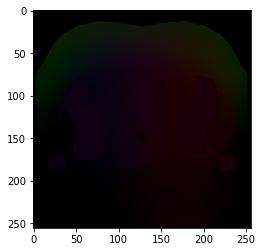

In [13]:
plt.imshow(uv_coarse_vertices[0].permute(1,2,0).cpu().numpy())

In [64]:
baldnet.fixed_uv_dis[None, None, :,:].shape

torch.Size([1, 1, 256, 256])

In [13]:
uv_detail_normals = displacement2normal(uv_z, coarse_verts, coarse_normals)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


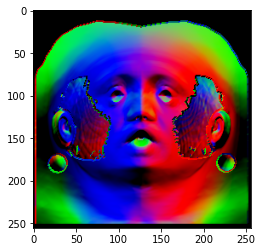

In [14]:
#with uv_z
plt.imshow(uv_detail_normals[0].permute(1,2,0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


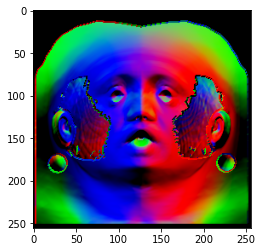

In [57]:
plt.imshow(uv_detail_normals[0].permute(1,2,0).cpu().numpy())

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


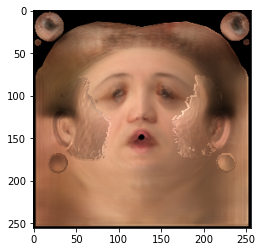

In [24]:
plt.imshow(opdict['uv_texture_gt'][0].permute(1,2,0).cpu().numpy())